# KTR Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktrlite import KTRLiteMAP
from orbit.models.ktrx import KTRXAggregated

from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.metrics import smape

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [6]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.38660,0.16888,-0.32831,0.11303
1,2010-01-10,13.62422,0.16888,-0.20470,0.16433
2,2010-01-17,13.39874,0.18514,-0.30233,0.11303
3,2010-01-24,13.13755,0.15235,-0.20470,0.10245
4,2010-01-31,13.19676,0.08335,-0.25232,0.07002


### Train / Test Split

In [7]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [13]:
ktr_stan = KTRLiteMAP(
    response_col='claims',
    date_col='week',
    # seasonality
    seasonality=52,
    seasonality_fs_order=5,
    level_knot_scale=.5,
    span_level=.1,
    span_coefficients=.3,
    rho_coefficients=.15,
    estimator_type=StanEstimatorMAP,
)

In [14]:
ktr_stan.fit(train_df)

In [15]:
predicted_df = ktr_stan.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52
0,2017-07-02,12.40007,12.37371,0.02636
1,2017-07-09,12.39214,12.37371,0.01843
2,2017-07-16,12.37149,12.37371,-0.00222
3,2017-07-23,12.34031,12.37371,-0.03341
4,2017-07-30,12.30210,12.37371,-0.07161


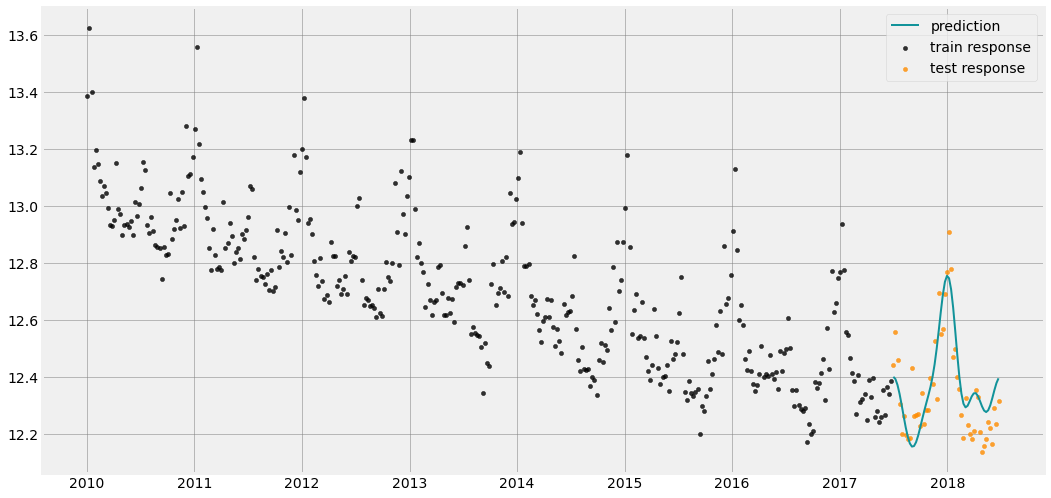

In [16]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

## KTRX

In [17]:
level_knot_dates = ktr_stan._level_knot_dates
level_knots = ktr_stan._aggregate_posteriors['map']['lev_knot'][0]
seasonal_knots_input = {
    '_seas_coef_knot_dates': ktr_stan._coef_knot_dates,
    '_sea_coef_knot': ktr_stan._aggregate_posteriors['map']['coef_knot'],
    '_sea_rho': ktr_stan.rho_coefficients,
    '_seasonality': ktr_stan._seasonality,
    '_seasonality_fs_order': ktr_stan._seasonality_fs_order,
} 

In [18]:
ktr_pyro = KTRXAggregated(
    response_col='claims',
    date_col='week',
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    level_knot_dates=level_knot_dates,
    level_knots=level_knots,
    seasonal_knots_input=seasonal_knots_input,
    level_knot_scale=.1, #.01
    span_coefficients=0.3,
    rho_coefficients=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    #learning_rate_total_decay=0.05,
    verbose=False,
    message=100,
    aggregate_method="median",
    estimator_type=PyroEstimatorVI,
)

In [19]:
ktr_pyro.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [20]:
predicted_df = ktr_pyro.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_input,regression
0,2017-07-02,12.37039,12.36388,0.02636,-0.01985
1,2017-07-09,12.38165,12.36388,0.01843,-0.00065
2,2017-07-16,12.35637,12.36388,-0.00222,-0.00528
3,2017-07-23,12.33205,12.36388,-0.03341,0.00157
4,2017-07-30,12.29769,12.36388,-0.07161,0.00542


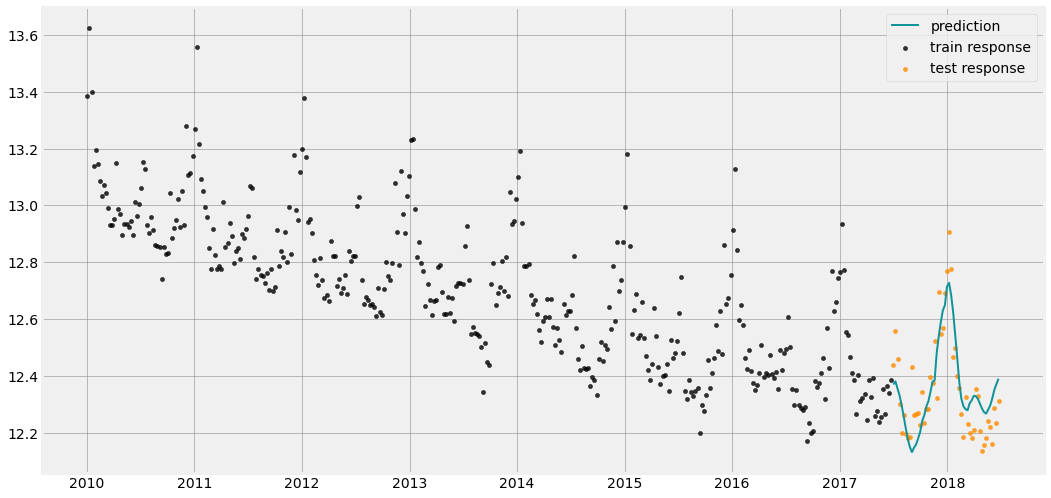

In [22]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)